#  Гипотезы о распределениях

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

# 1. Критерий Колмогорова


__Гипотеза о неизвестном законе распределения:__ 

$$
\begin{aligned}
H_0 : X \sim F_0 \\
H_1 : X \nsim F_0
\end{aligned}
$$

__Статистика:__ 

$$
K_n = \sqrt{n} \cdot \sup_{x} \mid \hat F_n(x) - F(x) \mid 
$$

При справедливости нулевой гипотезы распределение статистики $K_n$ одинаково для любого исходного непрерывного распределения.

## Упражнение 1 (искусство требует генераций)

Попробуем провести тест Колмогорова на нескольких искуственных примерах. 

In [2]:
x = stats.norm(loc=5, scale=3).rvs(1000)
stats.kstest(x, 'norm', args=(x.mean(), x.std(ddof=1)))

KstestResult(statistic=0.015231753060757747, pvalue=0.971762562213542)

Гипотеза о нормальности для выборки, сгенерированной из нормального распределения не отвергается. Сгенерируем выборку из равномерного распределения, а после протестируем гипотезу о нормальности.  

In [3]:
x = stats.uniform(0,1).rvs(1000)
stats.kstest(x, 'norm', args=(x.mean(), x.std(ddof=1)))

KstestResult(statistic=0.06785850061335325, pvalue=0.00018988339280542925)

Видим, что $p\_value$ очень низкое. Гипотеза о нормальности отвергается. По аналогии можно протестировать гипотезу для любого распределения. Вот пример с экспоненциальным распределением: 

In [4]:
x = stats.expon(scale=0.2).rvs(1000)
stats.kstest(x, 'expon', args=(0, x.mean()))

KstestResult(statistic=0.03131852952830383, pvalue=0.2747122148766792)

Первый аргумент отвечает за `loc` (экспоненциальное распределение со сдвигом). Он равен нулю.

## Упражнение 2 (акции)

Подгрузим данные о стоимости акций Яндекса в течение последних $10$ лет.

In [5]:
df = pd.read_csv('data/ynd.tsv', sep='\t')
df['fielddate'] = pd.to_datetime(df['fielddate'])
df.set_index('fielddate', inplace=True)
print(df.shape)
df.head()

(2291, 6)


,open,high,low,close,volume,adjusted
fielddate,,,,,,
2011-05-24,35.000000,42.009998,30.549999,38.840000,70186700.0,38.840000
2011-05-25,37.750000,37.900002,34.400002,35.000000,11761600.0,35.000000
2011-05-26,34.450001,35.450001,34.000000,34.770000,4417500.0,34.770000
2011-05-27,34.750000,35.000000,34.000000,34.450001,2006000.0,34.450001
2011-05-31,34.950001,35.369999,32.610001,33.450001,3981100.0,33.450001


Обычно финансисты работают с доходностями:

$$
R_t = \frac{P_t - P_{t-1}}{P_{t-1}}
$$

In [6]:
r = (df.close.diff()/df.close.shift(1)).dropna()
r

fielddate
2011-05-25   -0.098867
2011-05-26   -0.006571
2011-05-27   -0.009203
2011-05-31   -0.029028
2011-06-01   -0.035874
                ...   
2020-06-24    0.026531
2020-06-25    0.004970
2020-06-26   -0.030069
2020-06-29    0.004283
2020-06-30    0.015841
Name: close, Length: 2290, dtype: float64

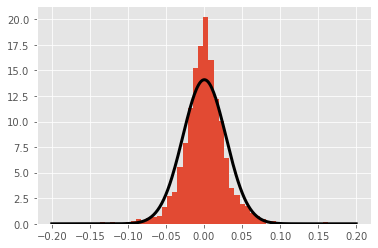

In [7]:
r.hist(bins=50, density=True);

xs = np.linspace(-0.2, 0.2, 300)
ys = stats.norm(loc=r.mean(), scale=r.std(ddof=1)).pdf(xs)
plt.plot(xs, ys, color="black", lw=3);

 Как это не странно, оно оказывается куполообразным. Издали распределение напоминает собой нормальное. Однако это ещё не факт. Можно заметить, что у распределения довольно тяжёлые хвосты. Чтобы увидеть это построим диаграмму квантиль-квантиль. Она позволяет сравнить выборочное распределение с теоретическим. 

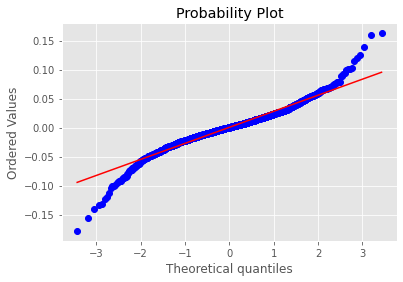

In [8]:
stats.probplot(r, dist="norm", plot=plt);

На диаграмме по оси $x$ откладываются значения из теоретического нормального распределения. По оси $y$ откладывают значения, которые фигурируют в выборке. Если бы наши наблюдения были из нормального распределения, они бы оказались на диагонали. Центр, действительно, укладывается на неё. А вот хвосты с неё спадают. Они оказываются тяжелыми.

Проверим гипотезу тестом Колмогорова. 

In [9]:
r.mean(), r.std(ddof=1)

(0.0005134013394187066, 0.02832192239992792)

In [10]:
stats.kstest(r, 'norm', args=(r.mean(), r.std(ddof=1)))

KstestResult(statistic=0.05845783509742103, pvalue=3.035955008495937e-07)

Гипотеза о нормальности отвергается, p_value оказалось очень маленьким. Обычно доходности моделируют с помощью распределений с тяжёлыми хвостами. Попробуем проверить ту же самую гипотезу, но с помощью критерия, специфицированного под хвосты [(Андерсона-Дарлинга)](https://www.statsmodels.org/stable/generated/statsmodels.stats.diagnostic.normal_ad.html#statsmodels.stats.diagnostic.normal_ad): мы переносим на хвосты распределения дополнительный вес, чтобы критерий был к ним более чувствительным. 

In [11]:
from statsmodels.stats.diagnostic import normal_ad
pval = normal_ad(r)
pval # гипотеза о нормальности отвергается

(19.749165127467677, 0.0)

Попробуем этот же тест для выборки из нормального распределения.

In [12]:
x = stats.norm(loc=5, scale=3).rvs(1000)
normal_ad(x)  # гипотеза о нормальности не отвергается

(0.23524769949358415, 0.7908735278957129)

## Упражнение 3 (однородность)

__Ещё одно полезное свойство критерия:__ можно проверять гипотезу об однородности выборок, то есть пытаться понять из одного ли распределения они к нам пришли. Колмогоров доказал, что для этого случая распределение Колмогорова тоже подходит.

In [13]:
x = stats.norm(loc=5, scale=3).rvs(50)
y = stats.norm(loc=5, scale=3).rvs(50)
z = stats.expon(scale=0.2).rvs(50)

In [14]:
stats.ks_2samp(x, y)

KstestResult(statistic=0.14, pvalue=0.7166468440414822)

In [15]:
stats.ks_2samp(x, z)

KstestResult(statistic=0.88, pvalue=2.3630419544297964e-20)

> __Важно:__  Критерий работает только для непрерывных распределений! Для дискретных ситуаций обычно используют критерий Пирсона. 

# 2. Критерий Пирсона


__Гипотеза о неизвестном законе распределения:__ 


$$
\begin{aligned}
H_0 : X \sim F_0 \\
H_1 : X \nsim F_0
\end{aligned}
$$

__Статистика:__ 

$$
\sum_{j=1}^s \frac{(v_j - n \cdot p_j(\hat \theta))^2}{n \cdot p_j(\hat \theta)} \sim \chi^2_{s - k - 1},
$$

где $\hat \theta$ - любая состоятельная оценка параметра, $v_j$ - частота, с которой значение $j$ встречалось в выборке, $p_j$ - теоретическая вероятность того, что выпадет значение $j$,  $s$ - число значений, которые может принимать случайная величина, $k$ - размерность вектора параметров $\theta$, 


## Упражнение 4 (число пи)

В десятичной записи числа $\pi$ среди первых $10002$ знаков после запятой цифры $0, 1, \dots, 9$ встречаются соответственно 968, 1026, 1021, 974, 1014, 1046, 1021, 970, 948, 1014 раз. Можно ли при уровне значимости $0.05$ считать эти цифры случайными? При каком уровне значимости эта гипотеза отвергается?

У нас есть дискретное распределение и $10$ вероятностей. Нужно проверить гипотезу о равномерности этого распределения. Будем делать это с помощью критерия Пирсона. 

In [16]:
n = 10002
X = np.array([968, 1026, 1021, 974, 1014, 1046, 1021, 970, 948, 1014])
p = X/n
p

array([0.09678064, 0.10257948, 0.10207958, 0.09738052, 0.10137972,
       0.10457908, 0.10207958, 0.0969806 , 0.09478104, 0.10137972])

In [17]:
p0 = np.array([1/10]*10)
p0

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

Статистика для теста Пирсона выглядит как

$$
\sum_{j=1}^{10} \frac{(v_j - n \cdot p_j(\hat \theta))^2}{n \cdot p_j(\hat \theta)} \sim \chi^2_{9},
$$

In [18]:
T = np.sum((X - n*p0)**2/(n*p0))
T

9.367726454709057

Статистика Пирсона имеет $\chi^2_9$. Найдём для неё критическое значения на уровне значимости $5\%$.

In [19]:
stats.chi2.ppf(0.95, df = 9)

16.918977604620448

Наблюдаемое значение меньше критического. Гипотеза о равномерности не отвергается. Найдём $p\_value$.

In [20]:
1 - stats.chi2.cdf(T, df = 9)

0.4040452075150309

Видим, что $p\_value$ на порядок выше $5\%$, значит гипотеза не отвергается. 

Ровно то же самое можно сделать встроенным тестом. 

In [21]:
from scipy.stats import chisquare
chisquare(X, f_exp=n*p0)

Power_divergenceResult(statistic=9.367726454709057, pvalue=0.40404520751503087)

> По аналогии с тестом Колмогорова, тест Пирсона можно использовать, чтобы проверять выборки на однородность. В таком случае критерий хочет получить на вход таблицу сопряжённости для двух распределений. 

## Упражнение 5 (снова однородность)

Мужчин и женщин опрашивают о их политических взглядах. Правда ли, что их распределение значимо различается. 

In [22]:
df = pd.DataFrame([[762, 327, 468], [484, 239, 477]])
df.columns = ["Democrat","Independent", "Republican"]
df.index = ["F", "M"]
df

,Democrat,Independent,Republican
F,762,327,468
M,484,239,477


In [23]:
df.values

array([[762, 327, 468],
       [484, 239, 477]], dtype=int64)

In [24]:
from scipy.stats import chi2_contingency
chi, pvalue, k, _ = chi2_contingency(df.values)

In [25]:
chi

30.070149095754672

In [26]:
pvalue

2.9535891832117595e-07

In [27]:
k

2

Гипотеза об однородности выборок отвергается. 